<a href="https://colab.research.google.com/github/gulabpatel/Causal_inference/blob/main/01_DAGRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* DagRegressor Documentation : https://causalnex.readthedocs.io/en/latest/03_tutorial/04_sklearn_tutorial.html

* causalnex.from_pandas Documentation : https://causalnex.readthedocs.io/en/latest/03_tutorial/01_first_tutorial.html

* YouTube Video : https://www.youtube.com/watch?v=BdGFg1FnHhQ

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
from IPython.display import display, Markdown
import pandas as pd

def variable_score_card(protected_variable: pd.Series, target: pd.Series, n_bins: int = 3):

    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_

    def pct_size():
        def pct_size_(x):
            return np.round(x.size / len(target) * 100, 1)
        pct_size_.__name__ = 'pct_size'
        return pct_size_

    display(Markdown("**Score card for ``%s``**" % protected_variable.name))

    agg_funcs = ["size", pct_size(), "mean", "std", "min", percentile(10), "median", percentile(90), "max"]
    if protected_variable.dtype != 'O' and protected_variable.nunique() < 10:
        return y.groupby(protected_variable).agg(agg_funcs).reset_index()
    else:
        bin_array = pd.cut(protected_variable, bins=n_bins)
        return y.groupby(bin_array).agg(agg_funcs).reset_index()

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
data = load_diabetes()
print(data["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [10]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")

variable_score_card(protected_variable=X["sex"], target=y)

**Score card for ``sex``**

,sex,size,pct_size,mean,std,min,percentile_10,median,percentile_90,max
0,-0.044642,235,53.2,149.021277,75.905781,25.0,59.4,140.0,266.8,346.0
1,0.050680,207,46.8,155.666667,78.453313,39.0,62.2,141.0,264.4,341.0


In [11]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: DPROG, Length: 442, dtype: float64

In [ ]:
variable_score_card(protected_variable=X["age"], target=y)

**Score card for ``age``**

,age,size,pct_size,mean,std,min,percentile_10,median,percentile_90,max
0,"(-0.107, -0.0346]",117,26.5,134.273504,69.369777,39.0,57.6,118.0,225.8,346.0
1,"(-0.0346, 0.0381]",212,48.0,153.278302,82.337721,25.0,53.0,140.5,272.0,341.0
2,"(0.0381, 0.111]",113,25.6,168.477876,70.996617,39.0,78.4,163.0,272.8,332.0


## Lets initially benchmark the performance of an ElasticNetCV fitted across the entire dataset.

In [ ]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.475


##Linear DAGRegressor

In [ ]:
!pip install causalnex

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

MEAN R2: 0.479
age    0.000000
sex    0.000000
bmi    0.304309
bp     0.180043
s1     0.000000
s2     0.000000
s3     0.000000
s4     0.000000
s5     0.277159
s6     0.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 802.08x480.96 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6505e13d0>)

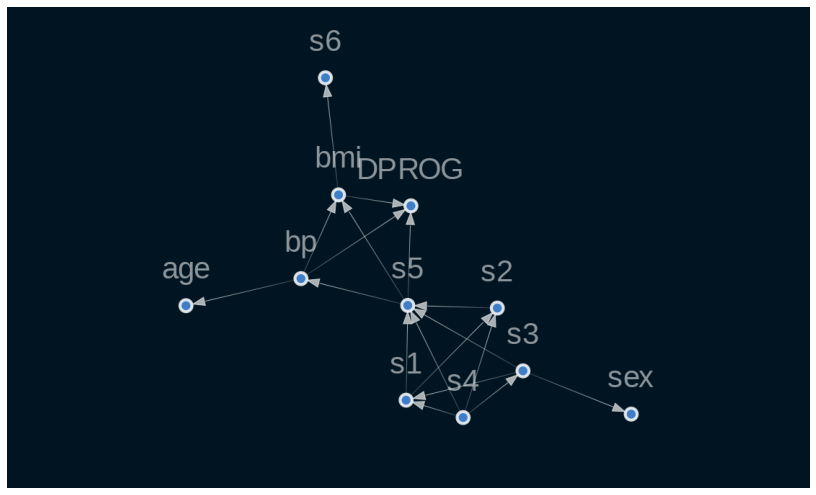

In [ ]:
from sklearn.datasets import load_diabetes
import torch
import causalnex
import pandas as pd
import numpy as np
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target

names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=None,
    dependent_target=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

##Nonlinear DAGRegressor

MEAN R2: 0.477
age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1    -0.646623
s2     0.481863
s3     0.000000
s4     0.000000
s5     0.548036
s6     0.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 621.36x357.84 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb65489d590>)

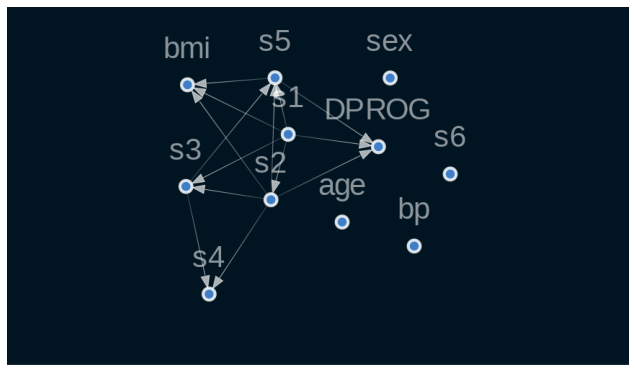

In [ ]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[2],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

##Dependent Target

MEAN R2: 0.373
age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1    -0.682699
s2     0.544426
s3     0.000000
s4     0.000000
s5     0.657404
s6     0.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 597.6x393.84 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb643a1c450>)

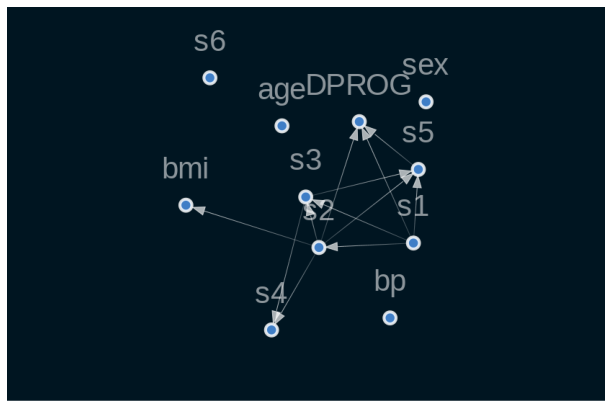

In [ ]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[2],
    dependent_target=False,
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

## Interpreting the nonlinear DAG
For nonlinear analysis, understanding the impact of one feature on another is not as simple as taking the mean effect as in the linear case. Instead, a combination of reg.coef_ and reg.feature_importances should be used:

* reg.coef_ provides the mean directional effect of all the features on the target. This gives average directional information, but can be misleading in terms of magnitude if the feature has a positive and negative effect on the target.

* reg.feature_importances_ provides the mean magnitude effect of the features on the target. These values will be strictly larger than the reg.coef_ because there are no cancellation effects due to sign differences.

The magnitude difference between the reg.coef_ and reg.feature_importances_ values can give insight into the degree of directional variability of the parameter:

* A large difference means that the parameter has large positive and negative effects on the target.

* A zero difference means that the parameter always has the same directional impact on the target.

MEAN R2: 0.425
MEAN EFFECT DIRECTIONAL:
age    0.000000
sex    0.000000
bmi    0.282831
bp     0.000000
s1    -0.637798
s2     0.498922
s3     0.000000
s4     0.000000
s5     0.535002
s6     0.000000
dtype: float64
MEAN EFFECT MAGNITUDE:
age    0.000000
sex    0.000000
bmi    0.290833
bp     0.000000
s1     0.637798
s2     0.498922
s3     0.000000
s4     0.000000
s5     0.535028
s6     0.000000
dtype: float64
Differences:
age    0.0
sex    0.0
bmi    0.0
bp     0.0
s1     0.0
s2     0.0
s3     0.0
s4     0.0
s5     0.0
s6     0.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 625.68x408.96 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6439559d0>)

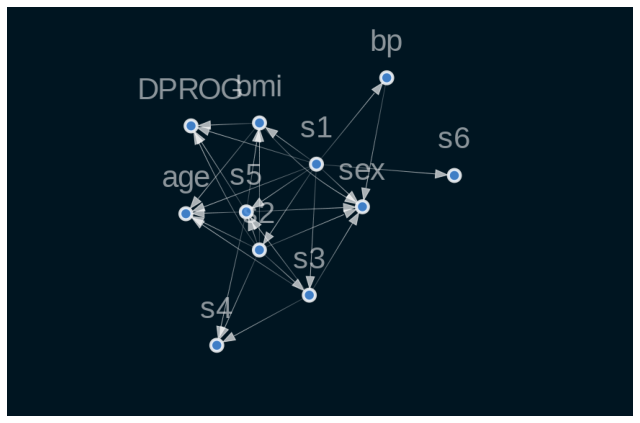

In [ ]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(0)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[5],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
print("Differences:")
print(pd.Series(reg.feature_importances_, index=names) - pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

The reg.get_edges_to_node method allows for analysis of other edges in the graph easily.

Passing in data="weight" returns the mean effect magnitude of the variables on the requested node. It is equivalent to the reg.feature_importances return for the target node.

Passing in data="mean_effect" returns the mean directional effect.

Below we show the effect of the variables on s3 as mean magnitude/absolute effect and mean directional effect.

In [ ]:
vals = reg.get_edges_to_node("s3", data="weight").copy()
vals[vals.abs() < 0.01] = 0
vals

age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1     1.235436
s2     1.125427
s3     0.000000
s4     0.000000
s5     0.000000
s6     0.000000
dtype: float64

In [ ]:
vals = reg.get_edges_to_node("s3", data="mean_effect")
vals[vals.abs() < 0.01] = 0
vals

age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1     1.235436
s2    -1.125427
s3     0.000000
s4     0.000000
s5     0.000000
s6     0.000000
dtype: float64

In [ ]:
reg.get_params()

{'alpha': 0.0001,
 'beta': 0.2,
 'dependent_target': True,
 'dist_type_schema': None,
 'enforce_dag': True,
 'fit_intercept': True,
 'hidden_layer_units': [5],
 'notears_mlp_kwargs': None,
 'standardize': True,
 'tabu_child_nodes': None,
 'tabu_edges': None,
 'tabu_parent_nodes': None,
 'target_dist_type': 'cont',
 'threshold': 0.0}

In [ ]:
reg.score(X, y)

0.5965683840323517